---

<div align=center>

# **Environement**

</div>

In [1]:
from src.train_model_tools import *

# !nvidia-smi
# !nvcc --version

2023-04-03 10:12:21.841253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-03 10:12:21.946442: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-03 10:12:23.615769: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-04-03 10:12:23.615838: W tensorflow/compiler/xla/stream_exe

Num GPUs Available:  1
Archive created at ./archives/2023-04-03_16812d1/2


---

<div align=center>

# **Configuration**

</div>

In [2]:
valid_frac = 0.2
test_frac  = 0.1
dataset_path = "data/dataset"
epochs = 100
batch_size=100
loss = 'mean_squared_error'
optimizer = 'SGD'
metrics = [
    tf.keras.metrics.MeanAbsoluteError(name="MAE"),
]

2023-04-03 10:12:28.429120: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21308 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3b:00.0, compute capability: 7.5


---

<div align=center>

# **Load data**

</div>

In [3]:
def load_file(file):

    data = np.load(file)

    x = {
        "Dust wavelenght": np.array([250.,]), # dust observation frequency [um]
        "Dust map" : data["dust_image"].reshape(*data["dust_image"].shape, 1), # adding a channel dimension
        "CO velocity" : data["CO_v"],
        "CO cube" : data["CO_cube"].reshape(*data["CO_cube"].shape, 1), # adding a channel dimension
        "N2H+ velocity" : data["N2H_v"],
        "N2H cube" : data["N2H_cube"].reshape(*data["N2H_cube"].shape, 1), # adding a channel dimension
    }
    
    y = {
        "Total mass" : np.array(data["mass"]),
        "Max temperature" : np.array(np.amax(data["dust_temperature"])),
    }

    return x, y

if os.path.isfile("data/dataset.npz"):
    dataset = np.load("data/dataset.npz")
    x = dataset["x"]
    y = dataset["y"]
    nb_vectors = dataset["nb_vectors"]
else:
    x, y, nb_vectors = load_data(load_file, dataset_path)
    np.savez_compressed("data/dataset.npz", x=x, y=y, nb_vectors=nb_vectors)

x_save = copy(x)
y_save = copy(y)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:02:125m0:02:11 eta 0:00:01
Number of vectors: 1000


---

<div align=center>

# **Model definition**

</div>

### Build model

Total params: 528,577.0
Trainable params: 528,577
Non-trainable params: 0.0


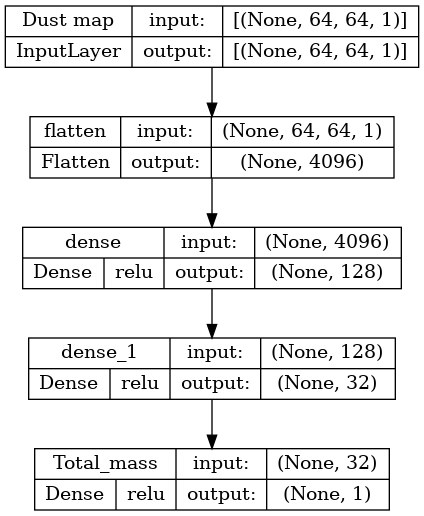

In [4]:
def get_model(sample_x):

    # Inputs ----------------------------------------------------------------------

    inputs = {
        "Dust map": Input(shape=sample_x["Dust map"].shape, name="Dust map"),
        # "CO cube": Input(shape=sample_x["CO cube"].shape, name="CO cube"),
    }

    # Network ---------------------------------------------------------------------

    # x1 = Conv2D(4, (8, 8), activation='relu', padding='same')(inputs["Dust map"])
    # x1 = MaxPooling2D((4, 4), padding='same')(x1)
    # x1 = Conv2D(8, (4, 4), activation='relu', padding='same')(x1)
    # x1 = MaxPooling2D((2, 2), padding='same')(x1)
    # x1 = Flatten()(x1)

    # x2 = Conv3D(4, (4, 4, 4), activation='relu', padding='same')(inputs["CO cube"])
    # x2 = MaxPooling3D((4, 4, 4), padding='same')(x2)
    # x2 = Conv3D(8, (4, 4, 4), activation='relu', padding='same')(x2)
    # x2 = MaxPooling3D((2, 2, 2), padding='same')(x2)
    # x2 = Flatten()(x2)

    # x = Concatenate()([x1, x2])

    x = Flatten()(inputs["Dust map"])
    x = Dense(128, activation='relu')(x)

    x_mass = Dense(32, activation='relu')(x)
    # x_temp = Dense(32, activation='relu')(x)

    # Outputs ---------------------------------------------------------------------

    outputs = {
        "Total mass" : Dense(1, activation='relu', name="Total_mass")(x_mass),
        # "Max temperature" : Dense(1, activation='relu', name="Max_temperature")(x_temp),
    }

    return Model(inputs, outputs)

# Compile, show and train -----------------------------------------------------

sample_x, _ = pick_vec(x, y, 0)
model = get_model(sample_x)
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
summary = get_summary(model)
print_model(model)

---

<div align=center>

# **Data post processing**

</div>

In [5]:
x, y = filter_data(model, x_save, y_save)
x_labels, y_labels = get_labels(x, y)
x_shapes, y_shapes = get_shapes(x, y)

x, y = shuffle(x, y)

x_normalized, x_means, x_stds = normalize(x)
y_normalized, y_means, y_stds= normalize(y)

train_x, train_y, valid_x, valid_y, test_x, test_y = split(x_normalized, y_normalized, valid_frac, test_frac)


print_shapes(x_labels, y_labels, x_shapes, y_shapes)
# show_random_vectors(x, y, x_means, y_means, x_std,y_stds)
print_means_stds(x_means | y_means, x_stds | y_stds)
pd.DataFrame.from_records([[nb_vec(train_x)], [nb_vec(valid_x)], [nb_vec(test_x)]], index=["Train", "Valid", "Test"], columns=["Nb vectors"]).transpose()

X shapes:
 - Dust map: (64, 64, 1)
Y shapes:
 - Total mass: ()


,Train,Valid,Test
Nb vectors,700,200,100


---

<div align=center>

# **Training**

</div>

### Training

In [6]:
history, training_time, score = train(model, train_x, train_y, valid_x, valid_y, test_x, test_y, epochs, batch_size)

Loss: 1.02e+00 | CPU: 1.7%, GPU: 2.0%, RAM: 10.1% (17.5GB/187.5GB) ━━━━━━━━━━ 100% 100/100 0:00:250:24 eta 0:00:00


### Results

In [ ]:
save_details(summary, loss, optimizer, metrics, valid_frac, test_frac, epochs, batch_size, training_time, score, nb_vectors, x_labels, y_labels)
plot_history(history)
add_record(x_labels, y_labels)

---

<div align=center>

# **Predictions**

</div>

In [ ]:
r = np.array([np.random.randint(0, nb_vectors)])
print(f"Random index: {r}")
x_prediction, y_expected = pick_vec(x_normalized, y, r)

print("Inputs:")
for key in x_prediction.keys():
    print(f" - {key}: {x_prediction[key].shape}")
print("Outputs:")
for key in y_expected.keys():
    print(f" - {key}: {y_expected[key].shape}")

y_prediction = model.predict(x_prediction)

for key in y_prediction.keys():
    y_prediction[key] = (y_prediction[key].flatten()[0] + y_means[key]) * y_stds[key]

    print(f"\n{key}:")
    print(f"   Predicted: {float(y_prediction[key]):.2e}")
    print(f"   Expected: {float(y_expected[key]):.2e}")

np.savez_compressed(f'{archive_path}/prediction.npz', x=x_prediction, y=y_prediction, expected=y_expected)